# Simppl

Probabilistic programming made (hopefully, maybe, though not quite) simple. What follows are some examples of what you can do with the language currently.

### Coin flip

Doesn't get simpler than this - modeling a coinflip with some uniform prior for the toss probabilities.

In [2]:
%matplotlib inline

from simppl.distributions import Pick, Flip, SomeValue, SomeThing
from simppl.utils import capture_locals, register_function
from simppl.inference import Exhaustive

import numpy as np

# All observations are 2D arrays, rows are samples, features are columns
tosses = np.array([0, 0, 0, 1, 0, 0]).reshape(-1, 1)

def coinflip_model(tosses=tosses):
    p = Pick('flip_probas', items=[0.1, 0.5, 0.8, 0.9])
    coinflip = Flip('coinflip', p=p, observations=tosses)
    
    capture_locals() # --> capture_locals grabs the state of all variables above it and records ,
                     # them at each execution...these values can then be inspected after inference...
    return coinflip
    

# Only one inference method available for now: Exhaustive for enumerating all possibilities
env = Exhaustive(coinflip_model)
env

☝️ As the help message told us above, inference methods return *Random Computation Environments* which contain information about the model and inference results...like the *executions* dataframe:

In [3]:
env.executions # Notice that all variables above "capture_locals" were captured here

,p,coinflip,_return_value_,_probability_
0,0.1,0,0,0.205508
1,0.1,1,1,0.205508
2,0.5,0,0,0.137712
3,0.5,1,1,0.137712
4,0.8,0,0,0.086864
5,0.8,1,1,0.086864
6,0.9,0,0,0.069915
7,0.9,1,1,0.069915


Posteriors can be computed as sum across executions:

<AxesSubplot:xlabel='p'>

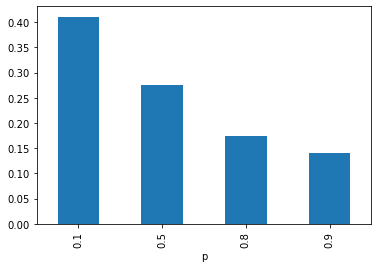

In [4]:
(env
 .executions
 .groupby('p')['_probability_']
 .sum()
 .plot.bar()
)

And models can be further inspected visually:


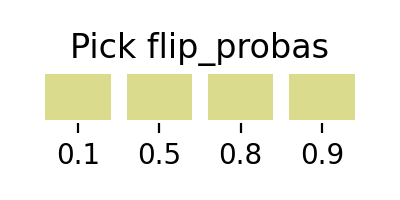

In [5]:
env.model

### Fermi calculation

We can use `simppl` to do quick Fermi calculations. Say that we want to answer the following:

"What is the mass of all the automobiles scrapped in North America this year?"

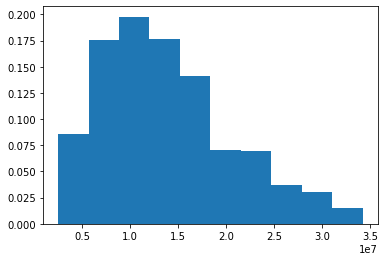

In [6]:
from matplotlib import pyplot as plt
def scrapped_cars_model():
    num_cars_scrapped = SomeValue('num_cars', between=[5, 20], around=[15]) # in millions
    car_mass = SomeValue('car_mass', between=[0.5, 2], mostly=1) # in tons
    return num_cars_scrapped * car_mass * 1e6

env = Exhaustive(scrapped_cars_model)

res = (env
 .executions
 .groupby('_return_value_')['_probability_']
 .sum()
 .reset_index()
)

plt.hist(res['_return_value_'], weights=res['_probability_']);


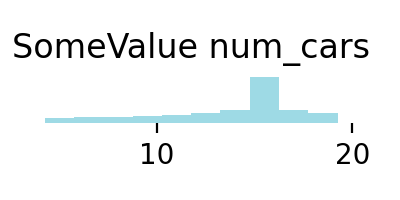

In [7]:
env.model

### Univariate cytotoxicity model 

A simple cytotoxicity model where growth inbibition is a sigmoid linearly dependant of the `log(concentration)` of a substance and its `toxicity`. We only consider a single concentration (but multiple possible observations at that same concentration) for this model.

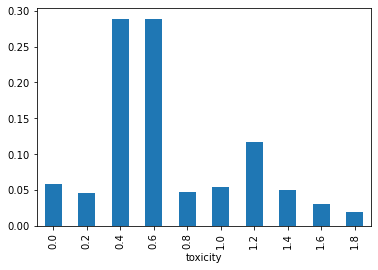

In [8]:
np.random.seed(1234)

def sigmoid_response(toxicity, log_concentration):
    return 1 / (1 + np.exp(toxicity * log_concentration))

log_concentration = 1
true_toxicity = 0.6
inhibitions = (sigmoid_response(true_toxicity, log_concentration) + np.random.randn(2) * 0.001).reshape(-1, 1)

def cytotoxicity_model(inibitions=inhibitions):
    toxicity = SomeValue('toxicity', between=[0, 2], around=[0, 1.5], mostly=1.3)
    inhibition = SomeValue(
        'inibition', 
        between=[0, 1], 
        mostly=sigmoid_response(toxicity, log_concentration),
        observations=inhibitions
    )
                        
    capture_locals()
    return inhibition

env = Exhaustive(cytotoxicity_model)
(env
 .executions
 .assign(toxicity=lambda df: np.round(df['toxicity'], 2))
 .groupby('toxicity')['_probability_']
 .sum()
 .plot.bar()
);

### Multivariate cytotoxicity model

Same as the above, but we consider multiple concentrations, in order to test the "multivariate" `SomeThing` distribution.

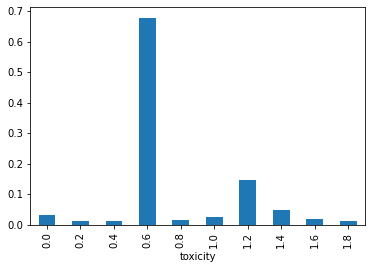

In [9]:
# Simulate some toxicity data
np.random.seed(1234)

log_concentrations = np.array([-5, -3, -1, 1, 2])
true_toxicity = 0.6 
n_obs = 2
inhibitions = (sigmoid_response(true_toxicity, log_concentrations) + np.random.randn(n_obs, 5) * 0.001)

# Sample inhibitions to define support for our SomeThing distribution
inhibition_space = np.random.uniform(
    low=sigmoid_response(0, log_concentrations),
    high=sigmoid_response(2, log_concentrations),
    size=(100, 5)
)

def cytotoxicity_model_mv(inibitions=inhibitions):
    toxicity = SomeValue('toxicity', between=[0, 2], around=[0, 1.5], mostly=1.3)
    inhibition = SomeThing(
        f'inibition', 
        samples=inhibition_space,
        resolution=80,
        mostly=sigmoid_response(toxicity, log_concentrations), # --> SomeThing is our "error model"
        observations=inhibitions
    )
                        
    capture_locals()

# Inference
env = Exhaustive(cytotoxicity_model_mv)

# Plot posterior for toxicity
(env
 .executions
 .assign(toxicity=lambda df: np.round(df['toxicity'], 2)) # round toxicities to second decimal for plotting
 .groupby('toxicity')['_probability_']
 .sum()
 .plot.bar()
);



### Pushing the `SomeThing` distribution further with molecules

The `SomeThing` distribution just needs a notion of similarity between the samples used to generate it since behind the scenes it's using a kernel method + nearest neighbor mapping -- we can use whatever objects we want. To illustrate this, we make a toy model for **molecular identification**, where we have an experiment that probes a molecule -- we call it `observable` here -- and theoretical means to simulate the `observable`. The challenge then is given a set of experimental `observables` and a set of candidate molecules, can we assign probabilities for these molecules. We use the `SomeThing` and `SomeValue` distributions for this purpose.

,molecule,_probability_
0,,0.106780
1,,0.106748
2,,0.106141
3,,0.105905
4,,0.097983
5,,0.097007
6,,0.096864
7,,0.095990
8,,0.093292
9,,0.093292

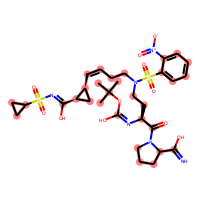
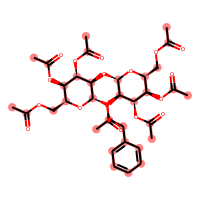
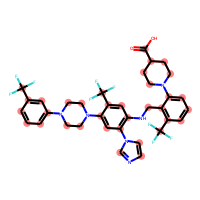
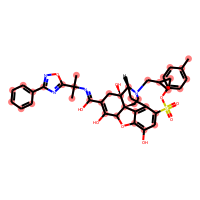
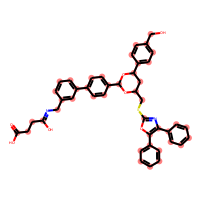
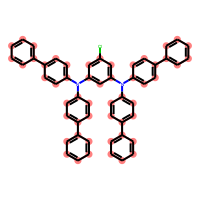
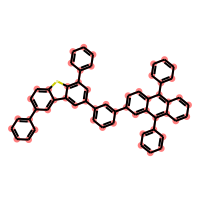
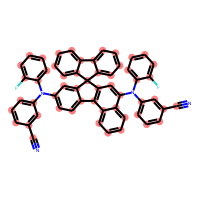
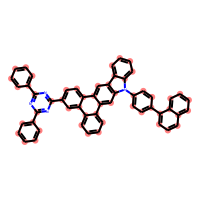
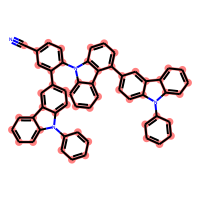

In [11]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

# These are SMILES structures for some random set of molecules from a CASMI challenge (http://www.casmi-contest.org/2017/index.shtml)
smiles = '''c1ccc2c(c1)cc(c1ccccc21)c1nc(c2ccc(cc2)c2ccc(cc2)n2c3ccccc3c3ccccc23)nc(c2cc3ccccc3c3ccccc23)n1	
CN(CCOC)CCOc1ccc(CN2C(=O)C(=C(C3(CCC3)N2C)O)C(=Nc2ccc(cc2c2cc(C(F)F)ncn2)C(F)(F)F)O)c(c1F)F	
c1ccc(cc1)c1ccc(c(c1)F)N(c1ccccc1)c1cc2c3ccccc3c(cc2c2ccccc12)N(c1ccccc1)c1ccc(cc1F)c1ccccc1	
c1cc(cc(c1)N1CCN(CC1)c1cc(c(cc1C(F)(F)F)NCc1c(cccc1N1CCC(CC1)C(=O)O)C(F)(F)F)n1ccnc1)C(F)(F)F	
c1ccc(cc1)n1c2ccccc2c2cc(ccc12)c1cccc(C#N)c1n1c2ccccc2c2cc(ccc12)c1ccc2c3ccccc3n(c3ccccc3)c2c1	
Cc1cc(C#N)cnc1C(=O)Nc1ccc(c([C@]2(CCOC)C(COC(=N2)NC(c2ccccc2)(c2ccc(cc2)OC)c2ccc(cc2)OC)(F)F)n1)F	
c1ccc(cc1)c1c2ccc(cc2sc1c1ccccc1)c1cccc(c1)c1c2ccccc2c(c2cccc(c2)c2cccc3ccccc23)c2ccccc12	
Cc1ccc(cc1)OS(=O)(=O)c1cc(c2c3c1C[C@@H]1[C@@]4(CC(=C(C([C@]34CCN1CC1CC1)O2)O)C(=NC(C)(C)c1nc(c2ccccc2)no1)O)O)O	
CCOc1nc2cccc(c2n1Cc1ccc(cc1)c1ccccc1c1nnn(COC(=O)Oc2ccc(cc2)CON(O)O)n1)C(=O)OCCCCON(O)O	
CCc1c(nc2cc(ccc2n1)F)O[C@@H]1C[C@H]2C(=N[C@@]3(C[C@H]3/C=C\CCCCC[C@@H](C(=O)N2C1)NC(=O)c1ccc(C)o1)C(=NS(=O)(=O)C1CC1)O)O	
c1ccc(cc1)n1c2ccccc2c2cc(ccc12)c1ccc2c(c1)c1ccccc1n2c1ccc(C#N)c(c1)c1ccc2c(c1)c1ccccc1n2c1ccccc1	
c1cc(cc(c1)C1[C@@H]([C@H]([C@@H]([C@@H](CO)O1)O)O)O)c1ccc(c(c1)O)[C@@H]1[C@@H](CC[C@@H](c2ccc(cc2)F)O)C(=O)N1c1ccc(cc1)CCc1cncs1	
c1ccc(cc1)c1cc(c2ccc3c4c2cccc4c2ccccc2O3)c2ccc3c(cc(c4ccc5c6c4cccc6c4ccccc4O5)c4ccc1c2c34)c1ccccc1	
CC1=C(CCOC(=Nc2ccccc2)O)SC2(C(=O)N(c3ccccc3)C(=O)N2c2ccccc2)N1Cc1cnc(C)nc1NC(=Nc1ccccc1)O	
c1ccc(cc1)n1c2ccccc2c2cc(ccc12)c1cccc2c1c1ccccc1n2c1ccc(cc1c1ccc2c(c1)c1ccccc1n2c1ccccc1)C#N	
CC(C)(C)OC(=N[C@@H](CCN(CC/C=C\[C@@H]1C[C@@H]1C(=NS(=O)(=O)C1CC1)O)S(=O)(=O)c1ccccc1N(=O)=O)C(=O)N1CCCC1C(=N)O)O	
c1cc(ccc1CN=C(O)OCC1[C@H]2[C@]3(C(CCN3C(=[NH2+])N1)(O)O)NC(=[NH2+])N2)C(=O)c1ccc(cc1)C(=NC[N-]C(=O)CC1[C@@H]2[C@H](CS1)N=C(N2)O)O	
c1ccc(cc1)c1c2cc(ccc2sc1c1ccccc1)c1ccc(cc1)c1c2ccccc2c(c2ccc(cc2)c2cccc3ccccc23)c2ccccc12	
CO[C@H]1C(COc2ccc(cc2)C=O)O[C@@H](C([C@@H]1O)O)O[C@H]1C(CO)O[C@@H](C([C@@H]1O)O)O[C@H]1C(COc2ccc(cc2)C=O)O[C@@H](C([C@@H]1O)O)OC	
COc1ccc(cc1)CN(Cc1ccc(cc1)OC)S(=O)(=O)c1c(ccc(C2CCC(CC2)N)c1c1nnn(Cc2ccc(cc2)OC)n1)C(F)(F)F	
COc1cc(cc(c1OC)OC)[C@@H]1c2cc(c(cc2[C@@H]([C@H]2COC(=O)[C@H]12)OC(=O)Cc1cccc2ccccc12)OCc1ccccc1)OCc1ccccc1	
CC(=O)OCC1C(CSc2nnc(c3ccncc3)o2)O[C@H](CCc2ccccc2N=C([C@H](Cc2ccc(cc2)c2ccccc2)N=C(O)OC)O)CN1	
c1ccc(cc1)C(c1ccccc1)(c1ccccc1)SCc1cc(cc(CNC(CSC(c2ccccc2)(c2ccccc2)c2ccccc2)C(=O)O)n1)C(=O)O	
c1cc(cc(c1)N1CCN(CC1)c1cc(c(cc1C(F)(F)F)NCc1cc(ccc1N1CCC(CC1)C(=O)O)C(F)(F)F)n1ccnc1)C(F)(F)F	
c1ccc2cc(ccc2c1)c1c(c2ccc(cc2)c2nc(cc(c3cc4ccccc4c4ccccc34)n2)c2cc3ccccc3c3ccccc23)n2ccccc2n1	
c1ccc(cc1)c1c(c2ccccc2)oc(n1)SCC1CC(c2ccc(cc2)CO)OC(c2ccc(cc2)c2cccc(c2)CN=C(CCC(=O)O)O)O1	
c1ccc2c(c1)c(cc1c2c2ccc(cc2C21c1ccccc1c1ccccc21)N(c1cccc(c1)C#N)c1ccccc1F)N(c1cccc(c1)C#N)c1ccccc1F	
c1ccc(cc1)n1c2ccccc2c2ccc3c4ccccc4n(c4ccccc4n4c5ccccc5nc4c4ccc5c6ccccc6c6ccccc6c5c4)c3c12	
C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]1[C@H]([C@H](OCCc2ccc(c(c2)O)O)O[C@H](CO[C@H]2[C@@H]([C@H]([C@@H]([C@@H](CO)O2)O)O)O)[C@H]1OC(=O)C=Cc1ccc(c(c1)O)O)O)O)O)O	
CCOC(=O)CC1CN=C(c2cc3cc(cc(c3[nH]2)OC(C)CO[Si](c2ccccc2)(C(C)(C)C)C(C)(C)C)Oc2ccc(cc2)S(=O)(=O)C)S1	
c1ccc(cc1)c1nc(c2ccccc2)nc(c2cccc(c2)c2ccc3c(c2)c2ccccc2c2cc4c(cc32)c2ccccc2n4c2ccc3ccccc3c2)n1	
c1ccc(cc1)Nc1ccc(cc1)N1C(=O)[C@H]2CC=C3[C@@H](C[C@@H]4[C@H]([C@H]3c3ccc5ccccc5c3O)C(=O)N(c3ccc(cc3)Nc3ccccc3)C4=O)[C@H]2C1=O	
CC(c1cccc(c1OCC1CO1)Oc1ccccc1)(c1cccc(c1OCC1CO1)Oc1ccccc1)c1cccc(c1OCC1CO1)Oc1ccccc1	
CC(=O)OC[C@@H]1[C@H]([C@@H]([C@H]([C@H](OCCc2ccccc2)O1)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](COC(=O)C)O1)OC(=O)C)OC(=O)C)OC(=O)C)OC(=O)C)OC(=O)C	
C[C@@]1(COc2cc(ccc2[C@H]1CCCCC(CCCCSCCCC(C(F)(F)F)(F)F)(C(=O)O)C(=O)O)OCOC)c1ccc(cc1)OCOC	
C=CCN(c1ccccc1)C(=O)[C@@H]1[C@H]2C(=O)N([C@H](CO)c3ccccc3)C(C(=O)N(CC=C)c3ccc(cc3)N(CC)CC)C32CC([C@H]1O3)Br	
CC(=O)Sc1ccc(C#Cc2cc(c(C#Cc3ccc(cc3)SC(=O)C)cc2OCc2ccc(cc2)C(C)(C)C)OCc2ccc(cc2)C(C)(C)C)cc1	
c1ccc(cc1)c1ccc(cc1)N(c1ccc(cc1)c1ccccc1)c1cc(cc(c1)N(c1ccc(cc1)c1ccccc1)c1ccc(cc1)c1ccccc1)Cl	
c1ccc2c(c1)c1ccccc1C12c2cccc3c(ccc(c4ccc(cc14)N(c1cccc(c1)C#N)c1ccccc1F)c23)N(c1cccc(c1)C#N)c1ccccc1F	
CC#Cc1c2cc3ccc(cc3cc2c(C#CC)c2cc3cc(C)c(C)cc3cc12)c1ccc2cc3c(C#CC)c4cc5c(ccs5)cc4c(C#CC)c3cc2c1	
C[C@H]1[C@@H](CSc2ccc(cc2)C(=O)O)O[C@@H](c2ccc(cc2)c2ccccc2CN2C(=O)CC(C2=O)N=C(O)OCc2ccccc2)O[C@H]1c1ccc(cc1)CO	
c1ccc(cc1)c1nc(c2ccccc2)nc(c2ccc3c(c2)c2ccccc2c2cc4c(cc32)c2ccccc2n4c2ccc(cc2)c2cccc3ccccc23)n1	
C/C(=C(\CCOC(=O)c1ccccc1)/SS(=O)/C(=C(\C)/N(Cc1cnc(C)[nH]c1=N)C=O)/CCOC(=O)c1ccccc1)/N(Cc1cnc(C)[nH]c1=N)C=O	
CC(C)(C)c1ccc(cc1)S(=O)(=O)Nc1c(c(nc(C2(C=CC=CN2)c2n[nH]nn2)n1)OCCOC(=Nc1ccccn1)O)Oc1ccccc1OC	
c1ccc(cc1)n1c2ccccc2c2cc(ccc12)C1=CC2C(=[N+]3c4c(cc(cc4S2)c2ccc4c(c2)c2ccccc2n4c2ccccc2)C2=C(C=CCC2)C3=O)C=C1	
C[C@H]1[C@@H]([C@H]([C@H]([C@H](OC[C@@H]2[C@H]([C@@H]([C@H]([C@H](Oc3cc(c4C(=O)C[C@@H](c5ccc(cc5)OC)Oc4c3)O)O2)O[C@H]2[C@@H]([C@@H]([C@H]([C@H](C)O2)O)O)O)O)O)O1)O)O)O	
C[C@H]1CN([C@@H](C)CO)C(=O)Cc2cc(ccc2O[C@H]1CN(C)S(=O)(=O)c1ccc(cc1)Oc1ccccc1)NC(=Nc1cccc(c1)C(F)(F)F)O	
C[C@@H](/C(=C/[N+]#N)/O)O[C@@H]1[C@H](C(=O)N1C(=P(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)OC(c1ccccc1)c1ccccc1)N=C(c1ccccc1)[O-]	
CC(C)(C)C1=CC(/C=C/2\C(C)(CCCC(=O)O)c3cc(ccc3N2CCCS(=O)(=O)O)S(=O)(=O)O)Oc2cc(ccc12)N(CCOC)CCOC	
CC(C)(C)[Si]1(C(C)(C)C)OC[C@@H]2[C@H]([C@@H](C(OC[C@@H]3[C@H]4[C@@H]([C@@H]5[C@H](O3)OC(C)(C)O5)OC(C)(C)O4)O2)OS(=O)(=O)c2ccccc2C(F)(F)F)O1	
C#Cc1ccc2c(c1)C(=NCc1c(C(=O)OCCCCCc3nc(c4CN=C(c5ccccc5)c5cc(C#C)ccc5n34)C(=O)O)ncn21)c1ccccc1F	
C=CC(=O)OCCCCOC1CCC(CC1)C(=O)OC1CCC(CC1)C(=O)Oc1ccc(c(c1C(F)(F)F)C(F)(F)F)OCCCCOC(=O)C=C	
CC1=C(C(=O)C(C)(C)C)N2C(=O)[C@@H]([C@@H]2S(=O)(=O)C1(Cc1ccccc1)Sc1nc(=O)c(nn1C)O[Si](c1ccccc1)(c1ccccc1)C(C)(C)C)OC	
c1ccc(cc1)c1ccc2c(c1)c1cc(cc(c3ccccc3)c1s2)c1cccc(c1)c1ccc2c(c1)c(c1ccccc1)c1ccccc1c2c1ccccc1	
c1ccc2c(c1)c1ccccc1C12c2cccc3c(ccc(c4ccc(cc14)N(c1ccc(cc1)C#N)c1ccc(cc1)F)c23)N(c1ccc(cc1)C#N)c1ccc(cc1)F	
CC(C)(C)OC(=N[C@H]1CCCCC/C=C\[C@H]2C[C@@]2(C(=NS(=O)(=O)N(C)C)O)N=C([C@@H]2C[C@H](CN2C1=O)OC(=O)N1Cc2ccc(cc2C1)Cl)O)O	
c1ccc(cc1)c1ccc2c(c1)c1ccccc1n2c1cccc(c1C#N)n1c2ccccc2c2c(cccc12)c1ccc2c(c1)c1ccccc1n2c1ccccc1	
c1ccc(cc1)c1cc(c2ccc(cc2)c2ccc3c(c2)c2cc4c5ccccc5oc4cc2o3)c(c2ccccc2)c2c3cccc4c5ccccc5c5cccc(c5c34)c12	
C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]1[C@H]([C@H](OCCc2ccc(c(c2)O)O)O[C@@H](CO)[C@H]1OC(=O)/C=C/c1ccc(c(c1)O)O)O)O[C@H]1[C@@H]([C@H]([C@H]([C@@H](CO)O1)O)O)O)O)O	
c1ccc(cc1)c1cccc(c1)c1ccc2c(c1)c1cc(cc(c3ccc(cc3)c3cc4ccccc4c4ccccc34)c1s2)c1cccc(c1)c1ccccc1	
c1ccc2cc(ccc2c1)c1c2ccccc2c(c2ccc3ccccc3c2)c2cc(ccc12)c1ccc2c(c1)nn(c1ccc(c3cccnc3)c3ccccc13)n2	
CCc1ccccc1n1c(c(cn1)c1nnn(Cc2cccc(C)c2)n1)SSc1c(cnn1c1ccccc1CC)c1nnn(Cc2cccc(C)c2)n1	
CCCCOC(=O)C(CC(C)(C)C(=O)OCCOC(=O)C(C)(C)CC(C1=CC(=O)N(CC(=O)O)C1=O)C(=O)OCCC)C1=CC(=O)N(CC(=O)O)C1=O	
c1ccc(cc1)Nc1ccc(cc1)N1C(=O)[C@H]2CC=C3[C@@H](C[C@@H]4[C@H]([C@H]3c3c5ccccc5ccc3O)C(=O)N(c3ccc(cc3)Nc3ccccc3)C4=O)[C@H]2C1=O	
CCc1cccc(c1)O[C@@H]1[C@H]([C@@H]([C@@H]([C@H](CO[C@@H]2[C@@H]([C@@H]([C@@H]([C@H](COC(=O)C)O2)OC(=O)C)OC(=O)C)OC(=O)C)O1)OC(=O)C)OC(=O)C)OC(=O)C	
CC(C)(C)OC(=N[C@@H](CN(CCC/C=C\[C@@H]1C[C@@H]1C(=NS(=O)(=O)C1CC1)O)S(=O)(=O)c1ccccc1N(=O)=O)C(=O)N1CCCC1C(=N)O)O	
Cc1cn([C@H]2C[C@@H]([C@@H](CO[C@]3(C[C@@H]([C@H]([C@H]([C@@H]([C@@H](COC(=O)C)OC(=O)C)OC(=O)C)O3)N=C(C)O)OC(=O)C)C(=O)OC)O2)N=[N+]=[N-])c(=O)nc1O	
CC1(C)COC(=O)[C@@H]1OC(=O)C=Cc1ccc(cc1)C(=O)O[C@@H]1CC(=C[C@@H]2[C@H]1OC1(Cc3ccccc3C1)O2)C(=NCc1cccc(c1)C(=NCCO)O)O	
C[C@H]1CC2C3CCC4=CC(=O)C=C[C@]4(C)[C@]3([C@H](C[C@]2(C)[C@]1(C(=O)COC(=O)CC(C(=O)OCC(CN(=O)=O)ON(=O)=O)N)OC(=O)CCCON(=O)=O)O)F	
C=CC(=O)OCCCCCCOc1ccc(cc1)C(=O)Oc1c(cc(cc1OC)C=NN=Cc1ccc(cc1)OOCc1ccc(cc1)OC(=O)C=C)OC	
Cc1cc2c(CCN[C@@]32CS[C@@H]2c4c([C@H](COC3=O)N3[C@@H](C#N)[C@H]5Cc6cc(C)c(c(c6[C@H](C23)N5)O)OC)c2c(c(C)c4OC(=O)C)OCO2)cc1O	
c1ccc(cc1)c1c(c2ccccc2)oc(n1)SCC1CC(c2ccc(cc2)CO)OC(c2cccc(c2)c2cccc(c2)CN=C(CCC(=O)O)O)O1	
c1ccc(cc1)P(c1ccccc1)c1ccccc1C(=N[C@@H]1c2ccccc2c2ccccc2[C@H]1N=C(c1ccccc1P(c1ccccc1)c1ccccc1)O)O	
c1ccc(cc1)N(c1cccc(c1)C#N)c1ccc2c(c1)C1(c3ccccc3c3ccccc13)c1cc(c3ccccc3c21)N(c1ccccc1)c1cccc(c1)C#N	
c1ccc(cc1)COP(=O)(OCc1ccccc1)OCC(COP(=O)(OCc1ccccc1)OCc1ccccc1)OCCOC1CCCCO1	
C/C=C/CCCCC[C@H]1C=C2[C@H]([C@@H]([C@@H]1C[C@H]1COC(C)(C)O1)C(=C(C[C@@]2(CC(=O)O)C(=O)OC)C(=O)OC)OS(=O)(=O)C(F)(F)F)SCC	
C/C(=C\C(=O)OCCCCCCCC(=Nc1c2c(css2)n(C(=O)C)c1=O)O)/CC1CC(C(C/C=C/C(C)C(C)OC(=O)C)(CO1)O)OC(=O)C	
Cc1ccc(cc1)c1c2ccccc2c(c2ccc(C)cc2)c2c3ccc(c4cccc(c34)c12)c1cc(cc2c3cc4ccccc4cc3sc12)c1ccccc1	
CC(C)C(=O)N=c1ccn([C@H]2C[C@@H]([C@@H](CCP(=O)(O)OCc3cc(ccn3=O)OC)O2)O[Si](c2ccccc2)(c2ccccc2)C(C)(C)C)c(n1)O	
Cc1c(cc2C(=O)C=CC(=NNc3ccccn3)c2n1)CN=c1[nH]c(=NCCS(=O)(=O)O)[nH]c(=NCc2cc3C(=O)C=CC(=NNc4ccccn4)c3nc2C)[nH]1	
c1ccc(c(c1)c1ccc(cc1)C1(c2cccc(c2)c2ccc3ccc4cccnc4c3n2)c2ccccc2c2ccccc12)c1ccc2ccc3cccnc3c2n1	
C[C@@H](C(=O)OCCOc1ccc(cc1)c1c(C#N)c(nc(c1C#N)SCc1csc(c2ccc(cc2)Cl)n1)N1CCCC1)N=C([C@H](CCCCNC)N)O	'''.split('\n')

molecules = np.array([Chem.MolFromSmiles(x.strip()) for x in smiles]).reshape(-1, 1)

# Precompute molecular fingerprints for similarity
fingerprints = {m : FingerprintMols.FingerprintMol(m) for m in molecules.flatten()}


# We need to register the RDKit's GetSubstructMatches function to be able to use it in our computation graph
def count_carbons(mol):
    return len(mol.GetSubstructMatches(Chem.MolFromSmiles('C')))
register_function('count_carbons', count_carbons, cls=Chem.rdchem.Mol)


def simulate_observable(molecule, constant):
    return constant * molecule[0].count_carbons()

def molecule_similarity(mols1, mols2):
    sims = [
        DataStructs.FingerprintSimilarity(
            fingerprints[mol1],
            fingerprints[mol2],
            metric=DataStructs.TanimotoSimilarity
        )
        for mol1 in mols1.flatten()
        for mol2 in mols2.flatten()
    ]
    return np.array(sims)

# Guess range for observable
o = np.array([simulate_observable(molecules[i, :], c) for i in range(molecules.shape[0]) for c in [0.5, 5]])
min_o, max_o = o.min(), o.max()

# Some toy observations
true_molecule = molecules[10, :]
true_constant = 2
n_obs = 2
toy_observables = (simulate_observable(true_molecule, true_constant) + np.random.randn(n_obs) * 0.01).reshape(-1, 1)

def molecule_observable_model(observables=toy_observables):
    molecule = SomeThing('molecule', samples=molecules, resolution=10, affinity=molecule_similarity)
    constant = SomeValue('constant', between=[0.5, 5], mostly=1)
    observable = SomeValue(
        'observable', 
        between=[min_o, max_o], 
        mostly=simulate_observable(molecule, constant),
        observations=observables
    )
    capture_locals()
    
# Inference
env = Exhaustive(molecule_observable_model)

from rdkit.Chem import PandasTools
from IPython.display import HTML

HTML(
    (env
     .executions
     .assign(
        molecule=lambda df: df['molecule'].apply(lambda x: x[0])
     )
     .groupby('molecule', sort=False,)['_probability_']
     .sum()
     .sort_values(ascending=False)
     .reset_index()
     .style.bar(subset=['_probability_'], color='lightblue')
     .render(escape=False)
    )
)

We can inspect different posteriors for different variables. For the `constant` used in the `observable` in our model:

<AxesSubplot:xlabel='constant'>

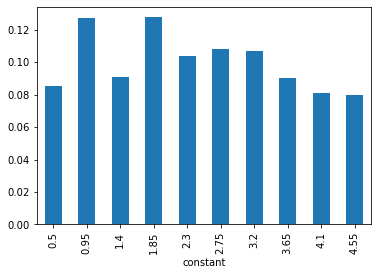

In [9]:
(env
 .executions
 .groupby('constant')['_probability_']
 .sum()
 .plot.bar()
);

...then for the actual molecules:

,molecule,_probability_
0,,0.106780
1,,0.106748
2,,0.106141
3,,0.105905
4,,0.097983
5,,0.097007
6,,0.096864
7,,0.095990
8,,0.093292
9,,0.093292

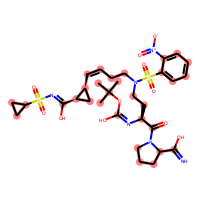
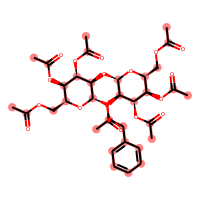
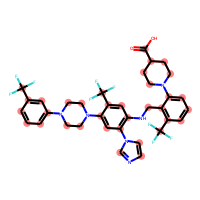
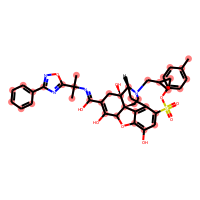
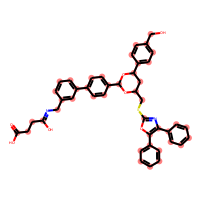
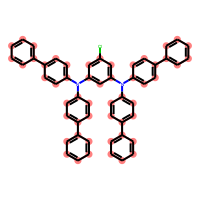
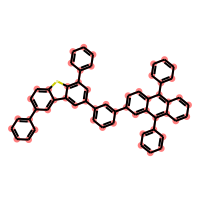
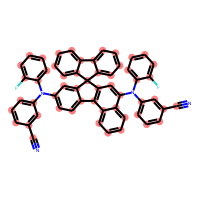
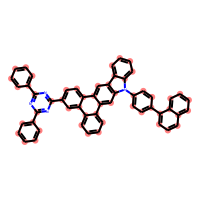
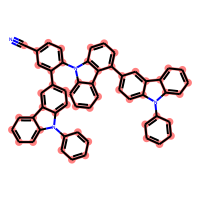

In [31]:
from rdkit.Chem import PandasTools
from IPython.display import HTML

HTML(
    (env
     .executions
     .assign(
        molecule=lambda df: df['molecule'].apply(lambda x: x[0])
     )
     .groupby('molecule', sort=False,)['_probability_']
     .sum()
     .sort_values(ascending=False)
     .reset_index()
     .style.bar(subset=['_probability_'], color='lightblue')
     .render(escape=False)
    )
)